Determine which bits are active if the differential standards (e.g. Differential SSTL) are used.

In [1]:
import zipfile
import os
import sys
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

from JicBitstream import JicBitstream, JicBitstreamZip
from knowledge import PU_ADDR
from knowledge2 import BLK_LOC_START_BIT, UNKNW_BLK_LOWER_LIM, UNKWN_BLK_NR

sys.path.append("../gen_bitstreams")
from PinInfoParser import PinInfoParser

%matplotlib notebook

In [2]:
def compare(lst, fn0, fn1, path0="../../results/out/", path1=None, verbose=False):
    if verbose:
        print(f"comparing {os.path.basename(fn0)} and {os.path.basename(fn1)}")
    if path1 is None:
        path1 = path0
    fn0 = os.path.join(path0, fn0)
    fn1 = os.path.join(path1, fn1)
    jic0 = JicBitstreamZip(fn0)
    jic1 = JicBitstreamZip(fn1)
    diff = jic0.diff_pos(jic1)
    if verbose:
        print(diff)
    lst.append(diff)

In [3]:
def is_checksum_blk(addr):
    diff = BLK_LOC_START_BIT - addr
    lo = 1 <= diff 
    hi = diff <= 16
    comb = lo * hi
    ret = np.any(comb)
    return ret

In [4]:
def offs_cor(addr, pin):
    addr -= (np.sum(addr > BLK_LOC_START_BIT) * 64)
    unknw_blk_lower_lim = UNKNW_BLK_LOWER_LIM[pin]
    unknw_blk_nr = UNKWN_BLK_NR[pin]
    
    if addr > unknw_blk_lower_lim:
        addr -= unknw_blk_nr*1344
        
    return addr

In [5]:
pin_list = open("../../resources/pin_list_5SGSMD5K1F40C1_8A.txt", "r").readlines()
pin_list = [pin.strip() for pin in pin_list]

In [6]:
STRATIXV_PIN_INFO = "../../resources/5sgsd5.txt"
parser = PinInfoParser(STRATIXV_PIN_INFO, "F1517")
pin_info = parser.get_all_pins()

In [7]:
IOSTD_ADDR_RX = {}

In [8]:
for pin in pin_list:
    print("\n", pin)
    
    if pin_info[pin].tx_rx_ch[-1] == "n":
        print("n pin, continuing...")
        continue
        
    if pin_info[pin].tx_rx_ch.find("DIFFIO_TX") == 0:
        print("TX pair, continuing...")
        continue
    
    diff_lst = []

    compare(diff_lst, f"{pin}_diff_sstl15_default.zip", f"{pin}_sstl15_default.zip")
    compare(diff_lst, f"{pin}_diff_sstl15_class1_default.zip", f"{pin}_sstl15_class1_default.zip")
    compare(diff_lst, f"{pin}_diff_sstl15_class2_default.zip", f"{pin}_sstl15_class2_default.zip")
    compare(diff_lst, f"{pin}_diff_sstl15_class1_term_off_10mA.zip", f"{pin}_sstl15_class1_term_off_10mA.zip")
    compare(diff_lst, f"{pin}_diff_sstl15_class1_term_off_8mA.zip", f"{pin}_sstl15_class1_term_off_8mA.zip")

    """
    compare(diff_lst, f"{pin}_diff_sstl15_default.zip", f"{pin}_sstl15_default.zip",
            path0="../../results/bidir", path1="../../results/bidir")
    compare(diff_lst, f"{pin}_diff_sstl15_class1_default.zip", f"{pin}_sstl15_class1_default.zip",
            path0="../../results/bidir", path1="../../results/bidir")
    compare(diff_lst, f"{pin}_diff_sstl15_class2_default.zip", f"{pin}_sstl15_class2_default.zip",
            path0="../../results/bidir", path1="../../results/bidir")
    """
    
    diff_lst_comb = []

    for diff in diff_lst:
        for el in diff[0]:
            if not is_checksum_blk(el):
                diff_lst_comb.append(offs_cor(el, pin))

    diff_lst_comb = np.array(sorted(list(set(diff_lst_comb))))
    X = diff_lst_comb.reshape(-1, 1)

    kmeans = KMeans(n_clusters=3, random_state=123).fit(X)
    print("K-means cluster centers", kmeans.cluster_centers_.reshape(-1))

    APPROX_PIN_LOC = int(1e6)
    PIN_GROUP = kmeans.predict(np.array([APPROX_PIN_LOC]).reshape(1, -1))
    feat_addrs = X[kmeans.labels_ == PIN_GROUP].reshape((-1))
    
    rel_to_pu = feat_addrs - offs_cor(PU_ADDR[pin], pin)
    # limits are set based on the observations
    rel_to_pu_sel = (rel_to_pu >= -5000) * (rel_to_pu <= 10000)
    rel_to_pu_trimmed = rel_to_pu[rel_to_pu_sel]

    print(rel_to_pu_trimmed)
    IOSTD_ADDR_RX[pin] = rel_to_pu_trimmed


 R32
K-means cluster centers [1.15831700e+06 2.68423584e+08 3.65000000e+03]
[-512 -480 -448 -416 -384 -352 -320 -256 -224 -192 -160 -128  -96  -64
  -32    0  544 1664]

 P32
n pin, continuing...

 U31
TX pair, continuing...

 T31
n pin, continuing...

 N32
K-means cluster centers [1.1068610e+06 2.6842358e+08 3.6540000e+03]
[-512 -480 -448 -416 -384 -352 -320 -256 -224 -192 -160 -128  -96  -64
  -32    0  544 1664]

 M32
n pin, continuing...

 N33
TX pair, continuing...

 M33
n pin, continuing...

 L33
K-means cluster centers [1.07761300e+06 2.68423584e+08 3.64900000e+03]
[-512 -480 -448 -416 -384 -352 -320 -256 -224 -192 -160 -128  -96  -64
  -32    0  544 1664]

 L34
n pin, continuing...

 P34
TX pair, continuing...

 N34
n pin, continuing...

 D33
K-means cluster centers [1.0261890e+06 2.6842358e+08 3.6530000e+03]
[-512 -480 -448 -416 -384 -352 -320 -256 -224 -192 -160 -128  -96  -64
  -32    0  544 1664]

 C33
n pin, continuing...

 B32
TX pair, continuing...

 A32
n pin, continui

In [9]:
addrs_rx = {}

for vals in IOSTD_ADDR_RX.values():
    for val in vals:
        try:
            addrs_rx[val] += 1
        except KeyError:
            addrs_rx[val] = 1

addrs_rx = {k: v for k, v in sorted(addrs_rx.items(), key=lambda item: item[0])}

<IPython.core.display.Javascript object>


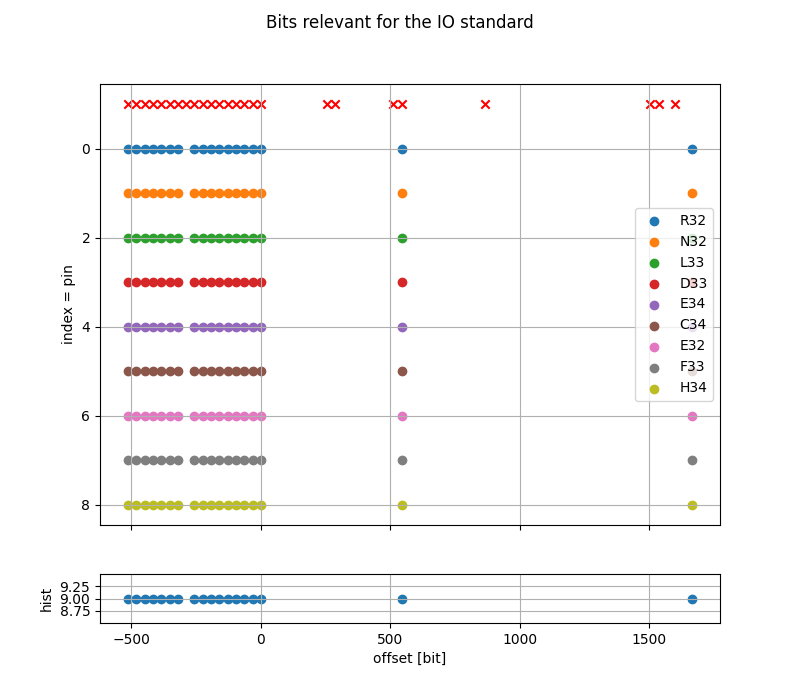

In [10]:
# all bits which were determined before to affect the IO standard
IO_STD_NON_DIFF = [
    -512,
    -480,
    -448,
    -416,
    -384,
    -352,
    -320,
    -288,
    -256,
    -224,
    -192,
    -160,
    -128,
    -96,
    -64,
    -32,
    0,
    256,
    288,
    512,
    544,
    864,
    1504,
    1536,
    1600,
]

fig = plt.figure(figsize=(8, 7))
ax, ax2 = fig.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [0.9, 0.1]})

import matplotlib.ticker as ticker
ticks = ["prev"]

for pos, (pin, val) in enumerate(IOSTD_ADDR_RX.items()):
    ax.scatter(val, np.ones(val.shape) * pos, label=pin)
    ticks.append(pin)
ax.scatter(IO_STD_NON_DIFF, np.ones(len(IO_STD_NON_DIFF)) * -1, marker="x", c="r")
ax.legend()

ax.invert_yaxis()
ax.grid(True)
ax.set_ylabel("index = pin")

ax2.scatter(addrs_rx.keys(), addrs_rx.values())
ax2.grid(True)
ax2.set_ylabel("hist")
ax2.set_xlabel("offset [bit]")

fig.suptitle("Bits relevant for the IO standard")

None

In [11]:
all_iostd_addrs_rx = set()
for k, vs in IOSTD_ADDR_RX.items():
    for v in vs:
        all_iostd_addrs_rx.add(v)
        
IO_STD_RX_DIFF = all_iostd_addrs_rx - set(IO_STD_NON_DIFF)
print("IO_STD_RX_DIFF =", list(IO_STD_RX_DIFF)[-1])

IO_STD_RX_DIFF = 1664


In [12]:
IOSTD_ADDR_TX = {}

In [13]:
for pin in pin_list:
    print("\n", pin)
    
    if pin_info[pin].tx_rx_ch[-1] == "n":
        print("n pin, continuing...")
        continue
        
    if pin_info[pin].tx_rx_ch.find("DIFFIO_RX") == 0:
        print("RX pair, continuing...")
        continue
    
    diff_lst = []

    compare(diff_lst, f"{pin}_diff_sstl15_default.zip", f"{pin}_sstl15_default.zip")
    compare(diff_lst, f"{pin}_diff_sstl15_class1_default.zip", f"{pin}_sstl15_class1_default.zip")
    compare(diff_lst, f"{pin}_diff_sstl15_class2_default.zip", f"{pin}_sstl15_class2_default.zip")
    compare(diff_lst, f"{pin}_diff_sstl15_class1_term_off_10mA.zip", f"{pin}_sstl15_class1_term_off_10mA.zip")
    compare(diff_lst, f"{pin}_diff_sstl15_class1_term_off_8mA.zip", f"{pin}_sstl15_class1_term_off_8mA.zip")
    
    diff_lst_comb = []

    for diff in diff_lst:
        for el in diff[0]:
            if not is_checksum_blk(el):
                diff_lst_comb.append(offs_cor(el, pin))

    diff_lst_comb = np.array(sorted(list(set(diff_lst_comb))))
    X = diff_lst_comb.reshape(-1, 1)

    kmeans = KMeans(n_clusters=3, random_state=123).fit(X)
    print("K-means cluster centers", kmeans.cluster_centers_.reshape(-1))

    APPROX_PIN_LOC = int(1e6)
    PIN_GROUP = kmeans.predict(np.array([APPROX_PIN_LOC]).reshape(1, -1))
    feat_addrs = X[kmeans.labels_ == PIN_GROUP].reshape((-1))
    
    rel_to_pu = feat_addrs - offs_cor(PU_ADDR[pin], pin)
    # limits are set based on the observations
    rel_to_pu_sel = (rel_to_pu >= -5000) * (rel_to_pu <= 10000)
    rel_to_pu_trimmed = rel_to_pu[rel_to_pu_sel]
    
    print(rel_to_pu_trimmed)
    IOSTD_ADDR_TX[pin] = rel_to_pu_trimmed


 R32
RX pair, continuing...

 P32
n pin, continuing...

 U31
K-means cluster centers [1.15831700e+06 2.68424924e+08 3.65400000e+03]
[-1856 -1824 -1792 -1760 -1728 -1696 -1664 -1600 -1568 -1536 -1504 -1472
 -1440 -1408 -1376 -1344  -800  1696]

 T31
n pin, continuing...

 N32
RX pair, continuing...

 M32
n pin, continuing...

 N33
K-means cluster centers [1.10686100e+06 2.68424924e+08 3.65400000e+03]
[-1856 -1824 -1792 -1760 -1728 -1696 -1664 -1600 -1568 -1536 -1504 -1472
 -1440 -1408 -1376 -1344  -800  1696]

 M33
n pin, continuing...

 L33
RX pair, continuing...

 L34
n pin, continuing...

 P34
K-means cluster centers [1.07764500e+06 2.68424926e+08 3.65800000e+03]
[-1856 -1824 -1792 -1760 -1728 -1696 -1664 -1600 -1568 -1536 -1504 -1472
 -1440 -1408 -1376 -1344  -800  1696]

 N34
n pin, continuing...

 D33
RX pair, continuing...

 C33
n pin, continuing...

 B32
K-means cluster centers [1.02618900e+06 2.68424926e+08 3.65800000e+03]
[-1856 -1824 -1792 -1760 -1728 -1696 -1664 -1600 -1568

In [14]:
addrs_tx = {}

for vals in IOSTD_ADDR_TX.values():
    for val in vals:
        try:
            addrs_tx[val] += 1
        except KeyError:
            addrs_tx[val] = 1

addrs_tx = {k: v for k, v in sorted(addrs_tx.items(), key=lambda item: item[0])}

<IPython.core.display.Javascript object>


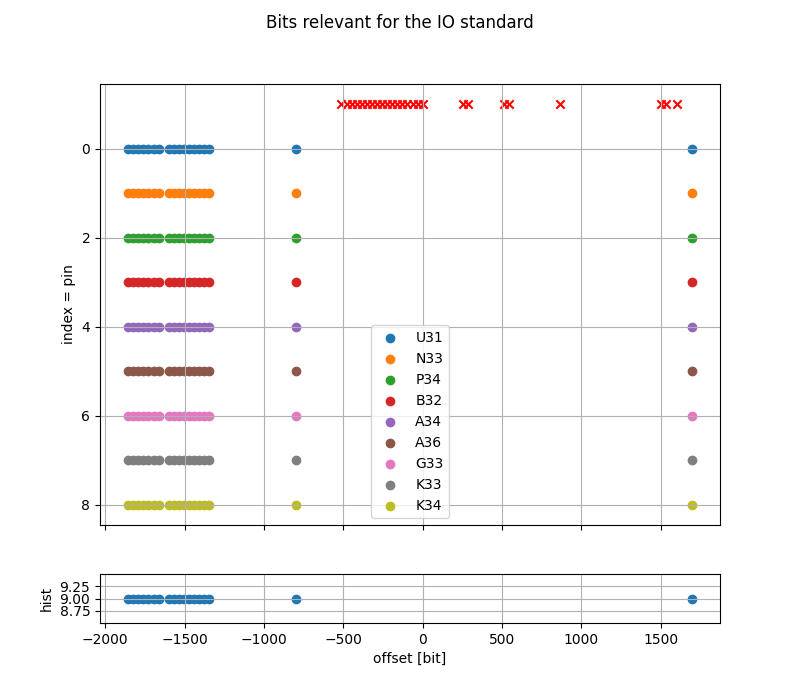

In [15]:
fig = plt.figure(figsize=(8, 7))
ax, ax2 = fig.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [0.9, 0.1]})

for pos, (pin, val) in enumerate(IOSTD_ADDR_TX.items()):
    # correction
    val_corr = np.copy(val)
    val_corr[val_corr != 1696] += 1344
    ax.scatter(val, np.ones(val.shape) * pos, label=pin)
ax.scatter(IO_STD_NON_DIFF, np.ones(len(IO_STD_NON_DIFF)) * -1, marker="x", c="r")
ax.legend()

ax.invert_yaxis()
ax.grid(True)
ax.set_ylabel("index = pin")

ax2.scatter(addrs_tx.keys(), addrs_tx.values())
ax2.grid(True)
ax2.set_ylabel("hist")
ax2.set_xlabel("offset [bit]")

fig.suptitle("Bits relevant for the IO standard")

None

In [16]:
all_iostd_addrs_tx = set()
for k, vs in IOSTD_ADDR_TX.items():
    for v in vs:
        all_iostd_addrs_tx.add(v)
        
IO_STD_TX_DIFF = all_iostd_addrs_tx - set(IO_STD_NON_DIFF)
print("IO_STD_TX_DIFF =", list(IO_STD_TX_DIFF)[-1])

IO_STD_TX_DIFF = 1696
